## Realistic Fall Detection in Real-World Streaming Scenarios with Costream

### Set things up

In [66]:
%load_ext autoreload
%autoreload 2

import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

# --- Costream Imports ---
from costream.data import make_csv_loader, group_files_by_subject
from costream.evaluation import run_subject_cv, ModelSpec, critical_difference
from costream.model import CostClassifierCV
from costream.evaluation.visualization import metric_box, window_bar

# Directories
RES_DIR = Path("results"); RES_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("figs"); FIG_DIR.mkdir(exist_ok=True)
DATA_DIR = Path("data")
FREQ = 100  # Hz

# Define Feature Extraction (Magnitude)
def calc_mag(df):
    raw_mag = np.sqrt(df['acc_x']**2 + df['acc_y']**2 + df['acc_z']**2)
    return raw_mag / 9.81  # Normalize by gravity

loader = make_csv_loader(
    feature_cols=['mag'], 
    label_col='label',
    new_features={'mag': calc_mag}
)

WINDOW_SIZES = [12]
CV_FOLDS = 5
FREQ = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load SisFall Dataset

In [67]:
# cols 7,8,9 -> acc_x, acc_y, acc_z in the MMA8451Q sensor
def get_g(arr):
    # Acceleration [g]: [(2*Range)/(2^Resolution)]*AD
    range = 8
    res = 14 # specified by authors
    return ((2*range)/2**res)*np.array(arr)

scale = (2 * 8) / (2**14)  # (2*Range)/(2^Resolution)
sisfall_dir = DATA_DIR / "sisfall"
# Load a sample text file to inspect
file = sisfall_dir / "SA01" / "D04_SA01_R01.txt"

# File is comma-delimited with trailing semicolons in fields; parse and clean
df = pd.read_csv(
    file,
    sep=",",
    header=None,
    usecols=[6, 7, 8],
    names=["acc_x", "acc_y", "acc_z"],
    engine="python",
)
# Strip trailing semicolons or stray characters
for col in ["acc_x", "acc_y", "acc_z"]:
    df[col] = df[col].astype(str).str.replace(r"[^0-9.\-]", "", regex=True)
    df[col] = df[col].astype(float)   
    # df[col] = get_g(df[col])
df = (df * scale)

<Axes: >

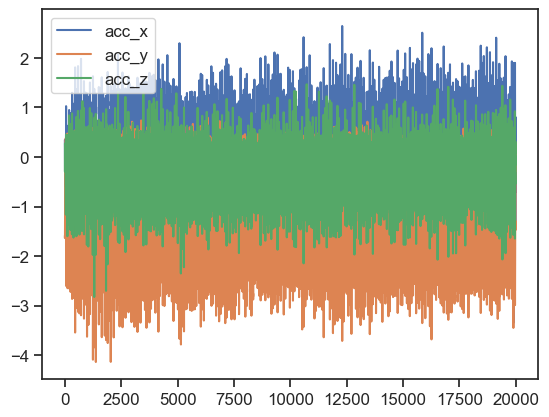

In [36]:
df.plot()

In [49]:
def sisfall_id_extractor(p: str) -> str:
    # Filenames like: D01_SA01_R01.txt
    name = os.path.splitext(os.path.basename(p))[0]
    s = name.split("_")[1]  # 'SA01'
    return s

def sisfall_transform(df):
    # Acceleration [g]: [(2*Range)/(2^Resolution)]*AD
    # Strip trailing semicolons or stray characters
    for col in ["acc_x", "acc_y", "acc_z"]:
        df[col] = df[col].astype(str).str.replace(r"[^0-9.\-]", "", regex=True)
        df[col] = df[col].astype(float)
    scale = (2 * 8) / (2**14)  # (2*Range)/(2^Resolution), specified by authors
    df = df * scale
    sisfall_mag = np.sqrt(df['acc_x']**2 + df['acc_y']**2 + df['acc_z']**2)
    return sisfall_mag # Already in g

def sisfall_label_logic(df, path):
    """
    1. Check filename: F=Fall, D=ADL.
    2. If Fall, find index of peak magnitude and mark it as 1.
    3. If ADL, fill with 0.
    """
    filename = path.name.upper()
    df['label'] = 0  # Default to ADL
    
    if filename.startswith('F'):
        # Calculate mag to find the impact point
        # (Assuming column 'mag' exist or were renamed in read_csv_kwargs)
        mag = df['mag']
        peak_idx = mag.idxmax()
        df.loc[peak_idx, 'label'] = 1  # Mark peak as impact point
    return df

sisfall_subj_map_paths = group_files_by_subject(
    sisfall_dir, file_pattern="**/*.txt", id_extractor=sisfall_id_extractor
)
all_sisfall_subject_data = {}
# cols 7,8,9 -> acc_x, acc_y, acc_z in the MMA8451Q sensor
sisfall_loader = make_csv_loader(
    feature_cols=['mag'], 
    new_features={'mag': sisfall_transform},
    sep=",",
    header=None,
    usecols=[6, 7, 8],
    names=["acc_x", "acc_y", "acc_z"],
    engine="python",
    label_extractor=sisfall_label_logic
)

for subj_id, file_paths in sisfall_subj_map_paths.items():
    all_sisfall_subject_data[subj_id] = sisfall_loader(file_paths)

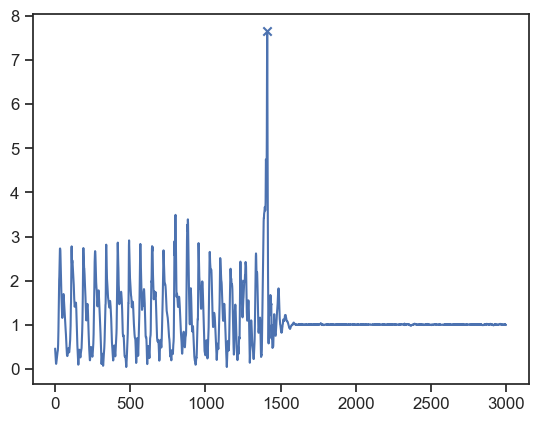

In [60]:
import matplotlib.pyplot as plt
onefall = all_sisfall_subject_data['SA01'][100]
plt.plot(onefall['mag'])
# indicate where label==1
one_idx = np.where(onefall['label']==1)
plt.scatter(one_idx, onefall['mag'].iloc[one_idx], marker='x')
plt.show()

In [62]:
# TrainTest Split (Subject-Wise)
sisfall_subjects = list(all_sisfall_subject_data.keys())
sisfall_split_file = RES_DIR / "sisfall_subject_split.json"
if sisfall_split_file.exists():
    with open(sisfall_split_file, "r") as f:
        sisfall_splits = json.load(f)
        sisfall_train_subjects = sisfall_splits["train"]
        sisfall_test_subjects = sisfall_splits["test"]
    print(f"Loaded saved {sisfall_split_file}.")
else:
    sisfall_train_subjects, sisfall_test_subjects = train_test_split(
        sisfall_subjects, test_size=0.2, random_state=42
    )
    with open(sisfall_split_file, "w") as f:
        json.dump(
            {"train": sisfall_train_subjects, "test": sisfall_test_subjects}, f, indent=4
        )
    print(f"Saved SisFall subject splits to {sisfall_split_file}")

# Verify no subject overlap
assert len(set(sisfall_train_subjects).intersection(set(sisfall_test_subjects))) == 0
sisfall_train_data_map = {s: all_sisfall_subject_data[s] for s in sisfall_train_subjects}

Loaded saved results/sisfall_subject_split.json.


In [74]:
# Visualise the classes, all samples and the mean in on plot
import matplotlib.pyplot as plt
from costream.segmentation import create_training_data
sisfall_dfs = []
for s in sisfall_subjects:
    sisfall_dfs.extend(all_sisfall_subject_data[s])
X_sisfall, y_sisfall = create_training_data(
    sisfall_dfs,
    feature_cols=['mag'],
    label_col='label',
    window_size=12,
    step=1,
    freq=200,
    spacing='na'
)

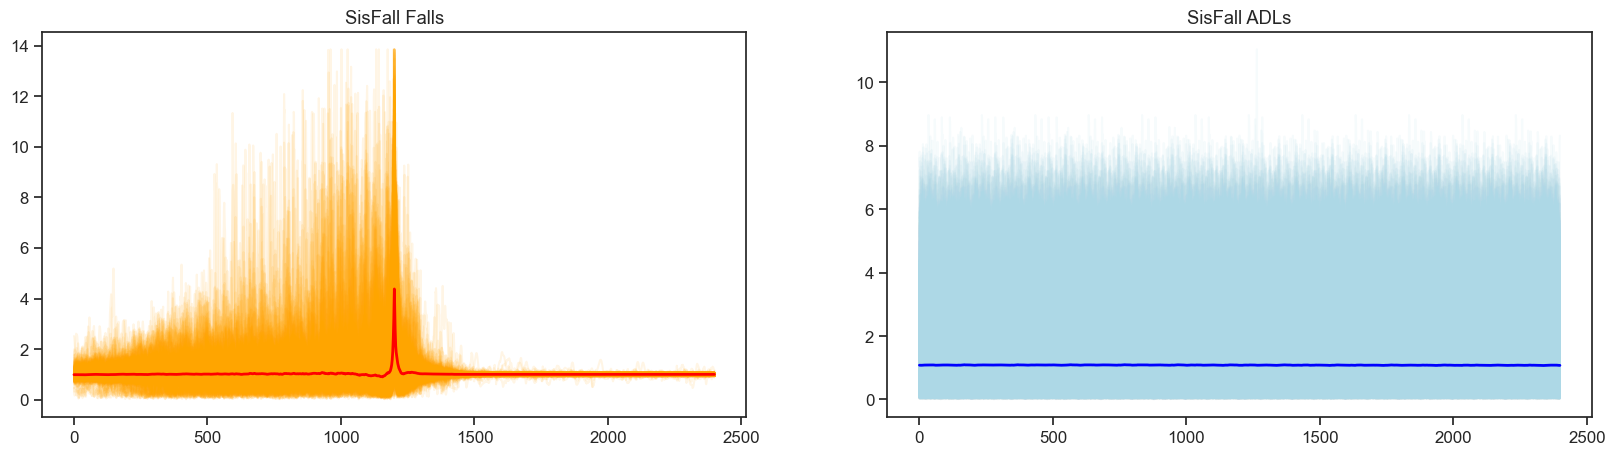

In [78]:
sisfall_falls = X_sisfall[y_sisfall == 1]
sisfall_adls = X_sisfall[y_sisfall == 0]
fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].plot(sisfall_falls.T, color='orange', alpha=0.1)
ax[0].plot(sisfall_falls.mean(axis=0), color='red', linewidth=2, label='Mean Fall')
ax[0].set_title('SisFall Falls')
ax[1].plot(sisfall_adls.T, color='lightblue', alpha=0.1)
ax[1].plot(sisfall_adls.mean(axis=0), color='blue', linewidth=2, label='Mean ADL')
ax[1].set_title('SisFall ADLs')
plt.show()

### Load Models

In [80]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesClassifier
from aeon.classification.convolution_based import MiniRocketClassifier
from aeon.classification.feature_based import Catch22Classifier
from aeon.classification.interval_based import QUANTClassifier
from aeon.classification.deep_learning import ResNetClassifier
from piping import PipingClassifier as Piping
from sklearn.dummy import DummyClassifier

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="loss", patience=20, min_delta=1e-4, restore_best_weights=True
)


def get_models(kind="real"):
    specs = []
    if kind == "baseline":
        # Dummy Baseline
        specs.append(
            ModelSpec("DummyADL", DummyClassifier(strategy="constant", constant=0))
        )
    else:
        specs.append(
            ModelSpec(
                "ExtraTrees",
                estimator=make_pipeline(
                    StandardScaler(),
                    SimpleImputer(strategy="mean", missing_values=np.nan),
                    ExtraTreesClassifier(
                        n_estimators=150,
                        max_features=0.1,
                        criterion="entropy",
                        random_state=42,
                    ),
                ),
            )
        )
        specs.append(
            ModelSpec(
                name="MiniRocket",
                estimator=make_pipeline(
                    StandardScaler(),
                    SimpleImputer(strategy="mean", missing_values=np.nan),
                    MiniRocketClassifier(n_jobs=-1, random_state=42),
                ),
            )
        )
        specs.append(
            ModelSpec(
                name="QUANT",
                estimator=make_pipeline(
                    StandardScaler(),
                    SimpleImputer(strategy="mean", missing_values=np.nan),
                    QUANTClassifier(random_state=42),
                ),
            )
        )
        specs.append(
            ModelSpec(
                name="Piping",
                estimator=make_pipeline(
                    SimpleImputer(strategy="mean", missing_values=np.nan),
                    Piping(scales=[5, 20, 30])
                ),
            )
        )
        specs.append(
            ModelSpec(
                name="Catch22",
                estimator=make_pipeline(
                    StandardScaler(),
                    SimpleImputer(strategy="mean", missing_values=np.nan),
                    Catch22Classifier(),
                ),
            )
        )
    return specs

In [81]:
# Real Models CV
sisfall_results = []
for win in WINDOW_SIZES:
    print(f"Running CV for window {win}s...")
    res = run_subject_cv(
        subject_map=sisfall_train_data_map,
        model_specs=get_models("real"),
        feature_cols=['mag'],
        window_size=12,
        cv=CV_FOLDS,
        step=1.0,
        spacing="na",
        verbose=True,
        freq=200, 
    )
    sisfall_results.append(res)
sisfall_results_df = pd.concat(sisfall_results, ignore_index=True)
sisfall_results_df.to_csv(RES_DIR / "sisfall_cv_results.csv")

Running CV for window 12s...

=== Fold 1/5 | Train Subjects: 24 | Test Subjects: 6 ===
  Segmented Train Data: (13052, 2400)
  Fold Results (Mean F1):
model
Catch22       0.959459
ExtraTrees    0.736292
MiniRocket    0.982456
Piping        0.932755
QUANT         0.966140
Name: f1-score, dtype: float64

=== Fold 2/5 | Train Subjects: 24 | Test Subjects: 6 ===
  Segmented Train Data: (13536, 2400)
  Fold Results (Mean F1):
model
Catch22       0.942792
ExtraTrees    0.718391
MiniRocket    0.991071
Piping        0.912442
QUANT         0.936768
Name: f1-score, dtype: float64

=== Fold 3/5 | Train Subjects: 24 | Test Subjects: 6 ===
  Segmented Train Data: (13299, 2400)
  Fold Results (Mean F1):
model
Catch22       0.971138
ExtraTrees    0.586364
MiniRocket    0.989967
Piping        0.886598
QUANT         0.944251
Name: f1-score, dtype: float64

=== Fold 4/5 | Train Subjects: 24 | Test Subjects: 6 ===
  Segmented Train Data: (13263, 2400)
  Fold Results (Mean F1):
model
Catch22       0.95798

In [86]:
sisfall_results_df.sort_values(by=["f1-score"], ascending=False)

,Unnamed: 0,model,tp,fp,tn,fn,runtime,delay,precision,recall,specificity,f1-score,auc,false alarm rate,miss rate,gain,thresh,fold
6,6,MiniRocket,222,3,3643,1,1.433037,-2.211979,0.986667,0.995516,0.999177,0.991071,0.997346,0.097414,0.032471,-0.162357,0.5,2
11,11,MiniRocket,296,2,4010,4,1.541782,-2.568440,0.993289,0.986667,0.999501,0.989967,0.993084,0.056151,0.112301,-0.280753,0.5,3
1,1,MiniRocket,224,7,4085,1,1.446306,-2.350389,0.969697,0.995556,0.998289,0.982456,0.996922,0.214638,0.030663,-0.275963,0.5,1
16,16,MiniRocket,300,12,3934,0,1.546211,-2.711447,0.961538,1.000000,0.996959,0.980392,0.998479,0.339964,0.000000,-0.339964,0.5,4
14,14,Catch22,286,3,4009,14,4.870232,-2.227820,0.989619,0.953333,0.999252,0.971138,0.976293,0.084226,0.393055,-0.870335,0.5,3
21,21,MiniRocket,428,4,4494,22,1.589515,-3.014188,0.990741,0.951111,0.999111,0.970522,0.975111,0.091605,0.503825,-1.099254,0.5,5
2,2,QUANT,214,4,4088,11,6.680260,-1.965210,0.981651,0.951111,0.999022,0.966140,0.975067,0.122650,0.337288,-0.797225,0.5,1
4,4,Catch22,213,6,4086,12,4.484820,-2.017986,0.972603,0.946667,0.998534,0.959459,0.972600,0.183975,0.367950,-0.919875,0.5,1
17,17,QUANT,277,1,3945,23,7.242379,-2.158457,0.996403,0.923333,0.999747,0.958478,0.961540,0.028330,0.651598,-1.331525,0.5,4
19,19,Catch22,285,10,3936,15,4.772952,-2.314801,0.966102,0.950000,0.997466,0.957983,0.973733,0.283303,0.424955,-1.133213,0.5,4


### Analysis and Plots

/Users/timilehin/code/costream/costream/evaluation/visualization.py:694: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=hue, bbox_to_anchor=(1.02, 1), loc="upper left")
/Users/timilehin/code/costream/costream/evaluation/visualization.py:694: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=hue, bbox_to_anchor=(1.02, 1), loc="upper left")


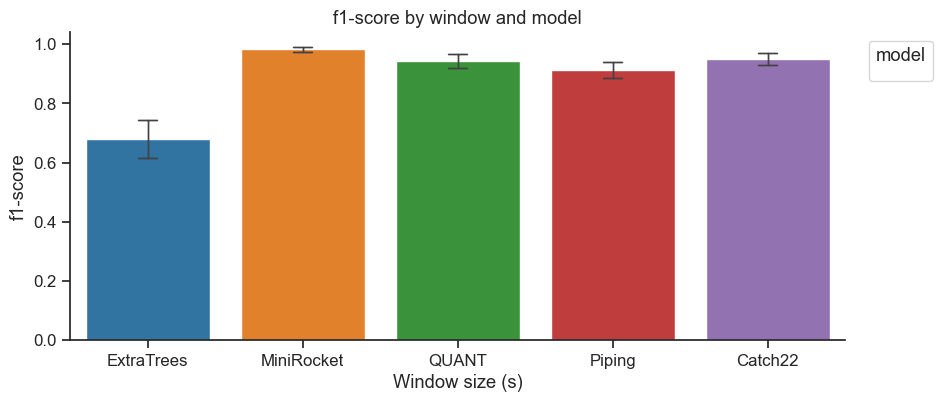

<Figure size 1000x600 with 0 Axes>

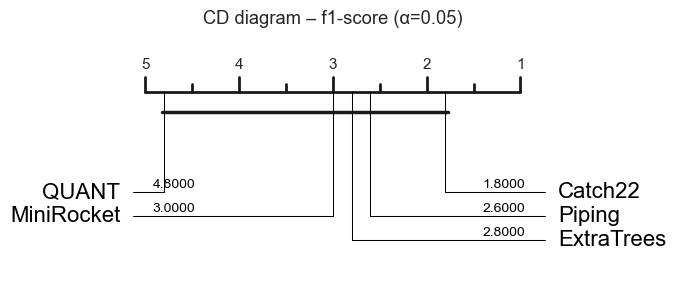

In [85]:
# Find Best Window Size (based on F1)
sisfall_results_df = pd.read_csv(RES_DIR / "sisfall_cv_results.csv")
plt.figure(figsize=(10, 4))
window_bar(sisfall_results_df, metric="f1-score", x="model", errorbar="sd")
window_bar(sisfall_results_df, metric="f1-score", x="model", errorbar="sd")
plt.show()

# Critical Difference Diagram (Requires aeon)
# # Ensure the dataframe has a 'fold' column (run_subject_cv adds this automatically)
try:
    critical_difference(sisfall_results_df, metric="f1-score")
except ImportError:
    print("Install 'aeon' to see Critical Difference diagram.")

### Cost Sensitive Threshold Tuning

In [6]:
%load_ext autoreload
%autoreload 2

from costream.segmentation import create_training_data
from costream.evaluation import run_experiment
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from costream.model import CostClassifierCV
from costream.data import extract_streaming_data
from aeon.classification.interval_based import QUANTClassifier

w = 10.0  # Best window size from previous step
fn_cost_factor = 2.0  # alpha

# Flatten the list of DFs for all training subjects
train_dfs_flat = []
for s in TRAIN_SUBJ:
    if s in all_subject_data:
        train_dfs_flat.extend(all_subject_data[s])

print(f"Generating Training Data (Window={w}s)...")
X_train, y_train = create_training_data(
    train_dfs_flat,
    feature_cols=['mag'],
    window_size=w,
    spacing="multiphase",
    freq=100,
    signal_thresh=1.4
)
print(f"Train Shape: {X_train.shape}, Class Balance: {np.bincount(y_train)}")

# --- Prepare Test Data (Continuous Streams) ---
print("Preparing Test Data...")

test_signals, test_events = extract_streaming_data(
    subject_map=all_subject_data,
    subjects=TEST_SUBJ,
    feature_col='mag',
    label_col='label'
)

print(f"Test Set: {len(test_signals)} recordings with {len(test_events)} events.")

base_model = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy="mean", missing_values=np.nan),
    QUANTClassifier(random_state=0),
)

tuned_model = CostClassifierCV(
    base_estimators=[
        make_pipeline(
            StandardScaler(),
            SimpleImputer(strategy="mean", missing_values=np.nan),
            QUANTClassifier(random_state=0),
        )
    ],
    method="stacking",
    alpha=2,
    random_state=0
)

specs = [ModelSpec("QUANT Untuned", base_model), ModelSpec("QUANT Alpha2", tuned_model)]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Generating Training Data (Window=10.0s)...
Train Shape: (5859, 1000), Class Balance: [5724  135]
Preparing Test Data...
Test Set: 21 recordings with 21 events.


In [6]:
print("Running Threshold Tuning Experiment...")
results_df = run_experiment(
    X_train, y_train,
    test_signals=test_signals,
    test_event_points=test_events,
    model_specs=specs,
    window_size=w,
    step=1.0,
    freq=100,
    tolerance=20,
    signal_thresh=1.4,
    verbose=True
)

print("\nResults:")
display(results_df)

results_df.to_csv(RES_DIR / "threshold_tuning_results.csv", index=False)

Running Threshold Tuning Experiment...
TRAINING 2 models...

TESTING on 21 recordings...
  Evaluating QUANT Untuned... Done.
  Evaluating QUANT Alpha2... Done.

Results:


,model,tp,fp,tn,fn,runtime,delay,precision,recall,specificity,f1-score,auc,false alarm rate,miss rate,gain,thresh
0,QUANT Untuned,17,1,24838,4,0.748901,-1.106667,0.944444,0.809524,0.999960,0.871795,0.904742,0.014359,0.057437,-0.129233,0.500000
1,QUANT Alpha2,18,2,24837,3,0.743243,-1.773333,0.900000,0.857143,0.999919,0.878049,0.928531,0.028718,0.043078,-0.114873,0.282828


### Visualise a specific trace

In [ ]:
from costream.segmentation import sliding_window_inference
from costream.evaluation import evaluate_recording, plot_confidence

tm = specs[1].estimator.fit(X_train, y_train) 
thresh = getattr(tm, "threshold_", 0.5)

In [14]:
tm.threshold_

0.17171717171717174

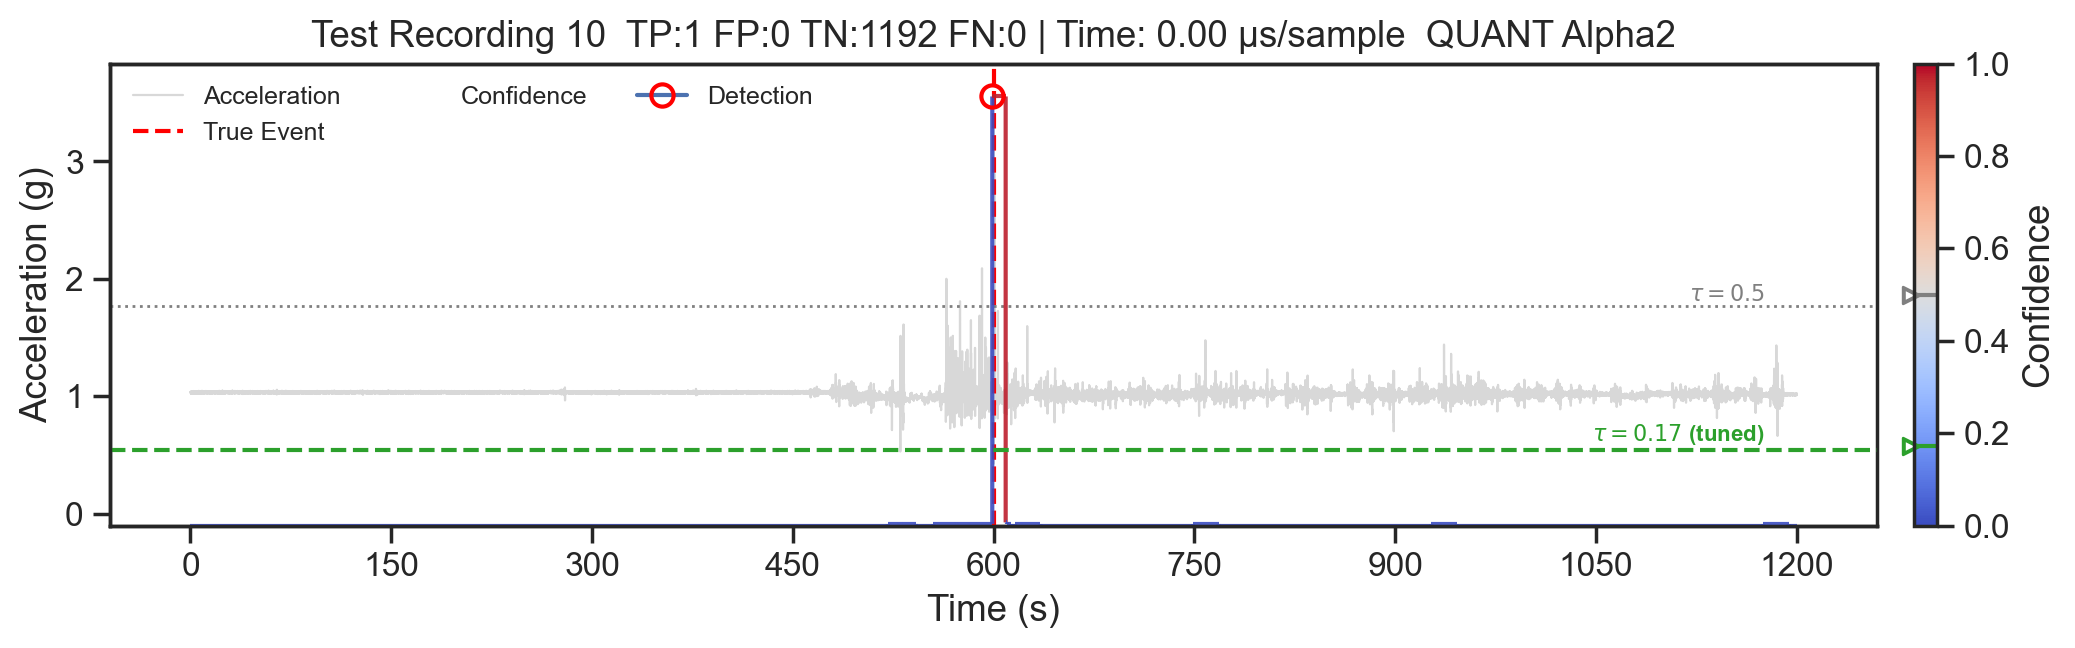

In [17]:
# Select a specific test recording (e.g., first one)
test_idx = 10
signal = test_signals[test_idx]
event_points = test_events[test_idx]

# Perform Sliding Window Inference
conf_map, runtime = sliding_window_inference(
    signal, model=tm, window_size=w, step=1.0, freq=100, signal_thresh=1.4
)

# Calculate stats for the title
cm, highs, _ = evaluate_recording(
    len(signal), event_points, conf_map, confidence_thresh=thresh, tolerance=20
)
tn, fp, fn, tp = cm.ravel()

plot_confidence(
    signal,
    conf_map,
    event_points,
    tp, fp, tn, fn,
    high_conf=highs,
    model_name="QUANT Alpha2",
    thresh_line=thresh,
    freq=100,
    title=f"Test Recording {test_idx}",
)

In [7]:
results_df = pd.read_csv(RES_DIR / "threshold_tuning_results.csv")
results_df

,model,tp,fp,tn,fn,runtime,delay,precision,recall,specificity,f1-score,auc,false alarm rate,miss rate,gain,thresh
0,QUANT Untuned,17,1,24838,4,0.748901,-1.106667,0.944444,0.809524,0.999960,0.871795,0.904742,0.014359,0.057437,-0.129233,0.500000
1,QUANT Alpha2,18,2,24837,3,0.743243,-1.773333,0.900000,0.857143,0.999919,0.878049,0.928531,0.028718,0.043078,-0.114873,0.282828


In [18]:
cm_tuned

array([[24837,     2],
       [    3,    18]])

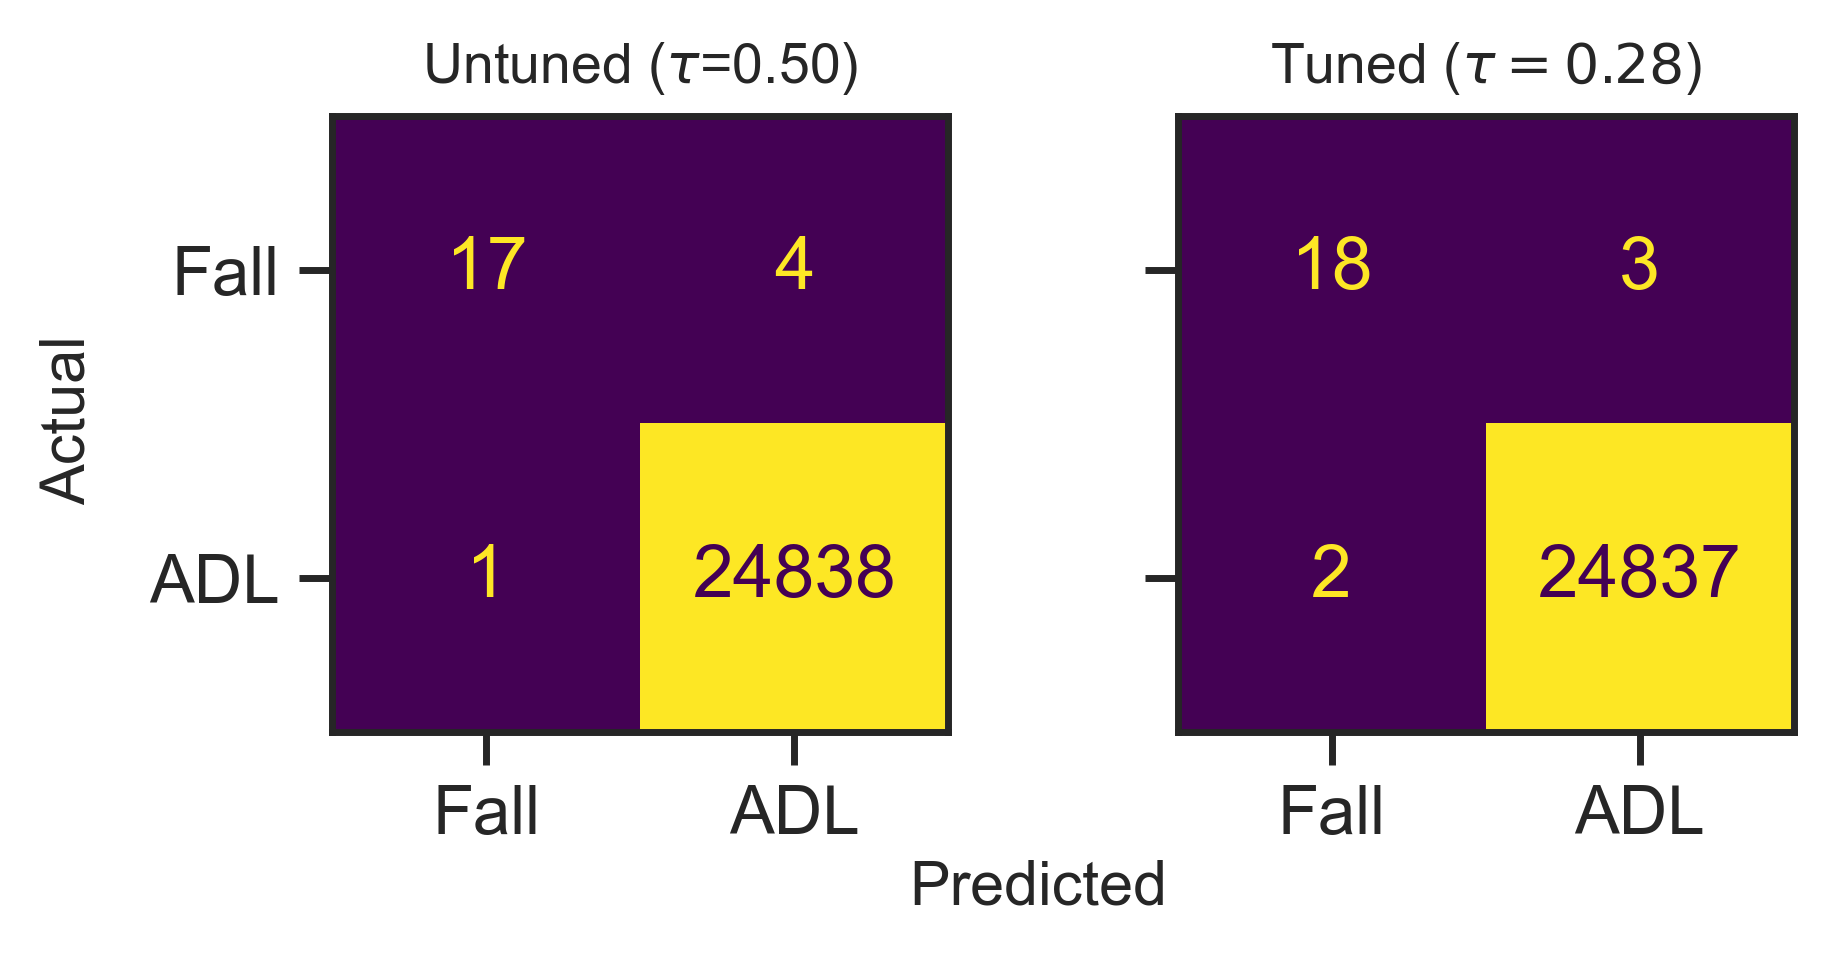

In [20]:
from costream.evaluation.visualization import plot_cm_comparison

cm_df = results_df[['model', 'tp', 'fp', 'tn', 'fn']]
cm_untuned = cm_df[cm_df['model'] == 'QUANT Untuned'][['tn', 'fp', 'fn', 'tp']].values[0]
cm_tuned = cm_df[cm_df['model'] == 'QUANT Alpha2'][['tn', 'fp', 'fn', 'tp']].values[0]
cm_untuned = cm_untuned.reshape(2,2)
cm_tuned = cm_tuned.reshape(2,2)
cm_untuned, cm_tuned

plot_cm_comparison(
    cm_untuned, 
    cm_tuned, 
    labels=["Fall", "ADL"],
    title_tuned=f"Tuned ($\\tau={0.282828:.2f}$)",
    save_path=FIG_DIR / "cm_comparison.pdf"
)

In [ ]:
quant_thresh_df = pd.read_csv(RES_DIR / "quant_thresh_metrics_19August.csv")
quant_thresh_df

,model,seed,window_size,runtime,delay,precision,recall,specificity,f1-score,auc,false alarm rate,miss rate,gain,thresh,fn_factor
0,QUANT,0,10,4.461270,-1.582857,0.863636,0.904762,0.999879,0.883721,0.952321,0.430776,0.287184,-0.000019,0.50000,2
1,QUANT,0,10,4.607384,-3.630476,0.840000,1.000000,0.999839,0.913043,0.999920,0.574367,0.000000,-0.000011,0.40404,2
